## Testings of SARIMAX model on hourly water consumption in Stuttgart
Landenwasserversorgung \
Weather data is from the station Stuttgart-Schnarrenberg

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pmdarima as pmd
import h5py
import json
import warnings
from utils.sarima_forecast import train_and_forecast_sarima

warnings.filterwarnings("ignore")

### 1.) Load Data

#### 1.1.) Read in water demand data

In [2]:
# Explore the structure of an HDF5 file
def explore_h5_structure(h5_file):
    for key in h5_file.keys():
        print(f"Group/Dataset: {key}")
        if isinstance(h5_file[key], h5py.Group):
            explore_h5_structure(h5_file[key])  # Recursively explore groups
        elif isinstance(h5_file[key], h5py.Dataset):
            print(f"Dataset shape: {h5_file[key].shape}, dtype: {h5_file[key].dtype}")

In [3]:
# Open the file
with h5py.File("../data/system_demand.h5", "r") as system_demand:
    explore_h5_structure(system_demand)

Group/Dataset: system_demand
Group/Dataset: n_nodal_datapoints_available
Dataset shape: (247463,), dtype: float64
Group/Dataset: nodal_demand_sum
Dataset shape: (247463,), dtype: float64
Group/Dataset: time
Dataset shape: (7, 247463), dtype: int64


In [4]:
with h5py.File("../data/system_demand.h5", "r") as system_demand:
    # Access a specific group
    group = system_demand["system_demand"]
    # Load the dataset into memory
    n_nodal_datapoints_available = group["n_nodal_datapoints_available"][:]
    nodal_demand = group["nodal_demand_sum"][:]
    system_time = group["time"][:]

In [5]:
# Build pandas df with datetime, nodal_demand_sum, n_nodal_datapoints_available
system_time_transposed = np.transpose(
    system_time
)  # transpose system time in long format
# create dataframe
df = pd.DataFrame(
    system_time_transposed,
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"],
)
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])
df["nodal_demand"] = nodal_demand
df["n_nodal_datapoints_available"] = n_nodal_datapoints_available
df.set_index("datetime", inplace=True)
df_hourly = df.resample(
    "h"
).mean()  # Use sum for total demand per hour.resample('h').mean() #resample to hourly mean demand in Liter/s
df_hourly = df_hourly.drop(
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"]
)
df_hourly.head(5)

,nodal_demand,n_nodal_datapoints_available
datetime,,
2016-12-30 23:00:00,3117.642772,29.0
2016-12-31 00:00:00,2509.771703,29.0
2016-12-31 01:00:00,2372.226333,29.0
2016-12-31 02:00:00,1912.399919,29.0
2016-12-31 03:00:00,1818.472781,29.0


In [6]:
df_hourly.describe()

,nodal_demand,n_nodal_datapoints_available
count,61867.000000,61867.000000
mean,3120.439133,31.586496
std,695.333672,1.700262
min,25.923525,5.000000
25%,2622.782434,30.000000
50%,3217.215857,31.000000
75%,3600.797019,33.000000
max,8641.782514,35.000000


#### 1.2.) Read in weather and holiday data

In [7]:
# Load the Raw temperature data
temperature = pd.read_csv(
    "../data/Temperaturdaten_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
)
temperature.index = pd.to_datetime(temperature.index, format="%Y%m%d%H")
temperature = temperature.rename_axis("datetime")
temperature.replace(-999, np.nan, inplace=True)  # Replace missing values with NaN
temperature.describe()

,STATIONS_ID,QN_9,TT_TU,RF_TU
count,406855.0,406855.000000,406721.000000,406682.000000
mean,4928.0,4.582512,10.496327,73.402686
std,0.0,2.796299,8.039577,17.937960
min,4928.0,1.000000,-21.200000,12.000000
25%,4928.0,3.000000,4.500000,61.000000
50%,4928.0,3.000000,10.500000,77.000000
75%,4928.0,5.000000,16.200000,88.000000
max,4928.0,10.000000,37.900000,100.000000


In [8]:
temperature.head(5)

,STATIONS_ID,QN_9,TT_TU,RF_TU,eor
datetime,,,,,
1977-07-01 01:00:00,4928,5,14.8,79.0,eor
1977-07-01 02:00:00,4928,5,14.2,83.0,eor
1977-07-01 03:00:00,4928,5,13.6,83.0,eor
1977-07-01 04:00:00,4928,5,13.3,88.0,eor
1977-07-01 05:00:00,4928,5,13.1,88.0,eor


In [9]:
# Read in holiday data for Bade-Württemberg - set as binary variable
for year in range(2016, 2023):
    with open(f"../data/holidays/feiertage_bw_{year}.json", "r") as f:
        holidays = json.load(f)
        holiday_dates = []
        for key in holidays.keys():
            holiday_dates.append(holidays[key]["datum"])
        holiday_dates = pd.to_datetime(holiday_dates, format="%Y-%m-%d")
        df_hourly["holiday"] = df_hourly.index.isin(holiday_dates).astype(int)

In [10]:
df_merged = pd.merge(
    df_hourly, temperature[["TT_TU", "RF_TU"]], on="datetime", how="left"
)
df_merged.head(5)

,nodal_demand,n_nodal_datapoints_available,holiday,TT_TU,RF_TU
datetime,,,,,
2016-12-30 23:00:00,3117.642772,29.0,0,-2.9,89.0
2016-12-31 00:00:00,2509.771703,29.0,0,-3.5,90.0
2016-12-31 01:00:00,2372.226333,29.0,0,-3.8,90.0
2016-12-31 02:00:00,1912.399919,29.0,0,-4.4,91.0
2016-12-31 03:00:00,1818.472781,29.0,0,-4.7,92.0


### 2.) Investigate the data

#### 2.1.) Yearly basis

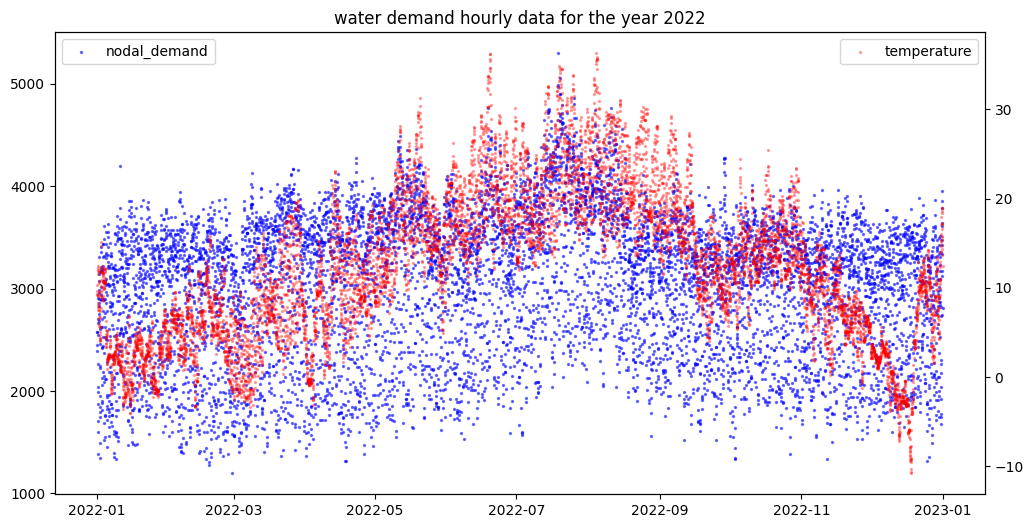

In [11]:
start_date = pd.Timestamp("2022-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="nodal_demand",
    color="blue",
)
# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.scatter(
    year_data.index,
    year_data["TT_TU"],
    s=2,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="temperature",
    color="red",
)

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title(f"water demand hourly data for the year {start_date.year}")
plt.show()

#### 2.2.) Weekly basis

In [12]:
start_date = "2023-07-03"
end_date = "2023-07-25"
filtered_df = df_merged[(df_merged.index >= start_date) & (df_merged.index < end_date)]
filtered_df.describe()

,nodal_demand,n_nodal_datapoints_available,holiday,TT_TU,RF_TU
count,528.000000,528.0,528.0,528.000000,528.000000
mean,3569.438062,35.0,0.0,22.290909,51.990530
std,683.681048,0.0,0.0,4.629936,17.143825
min,1565.340237,35.0,0.0,12.700000,20.000000
25%,3087.076787,35.0,0.0,18.800000,38.000000
50%,3688.075929,35.0,0.0,21.700000,49.000000
75%,4071.982150,35.0,0.0,24.900000,63.000000
max,5198.860020,35.0,0.0,35.300000,97.000000


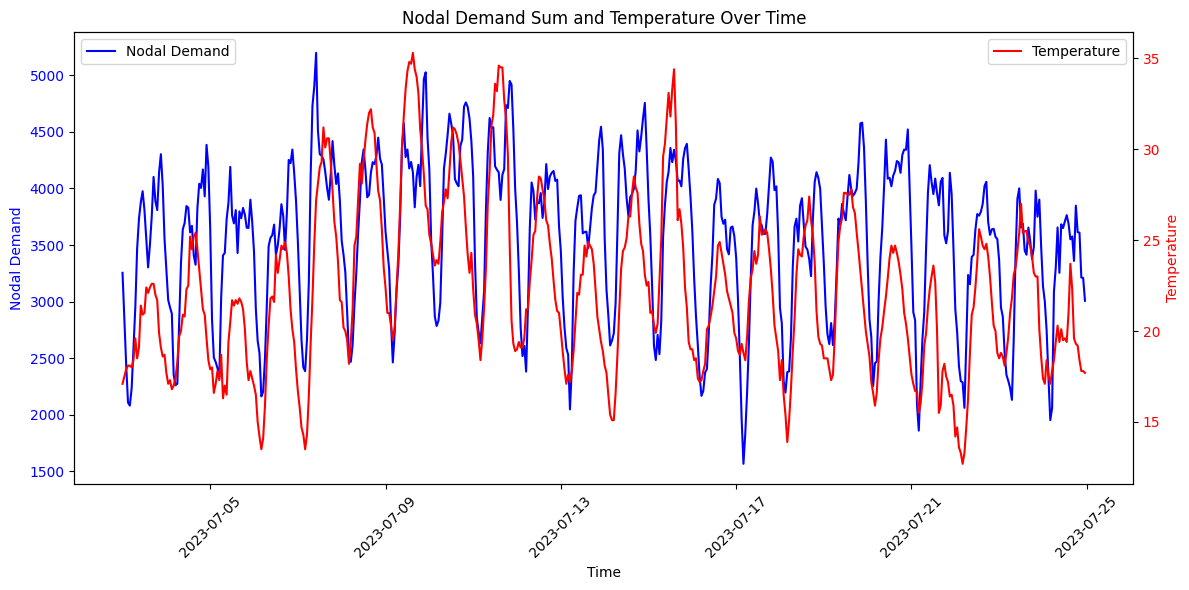

In [13]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the nodal_demand_sum
ax1.plot(
    filtered_df.index, filtered_df["nodal_demand"], label="Nodal Demand", color="b"
)
ax1.set_xlabel("Time")
ax1.set_ylabel("Nodal Demand", color="b")
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(filtered_df.index, filtered_df["TT_TU"], label="Temperature", color="r")
ax2.set_ylabel("Temperature", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Nodal Demand Sum and Temperature Over Time")
plt.tight_layout()
plt.show()

### 3.) Build SARIMA model - One day ahead forecast

#### 3.1.) Identifying the dependence orders of the model

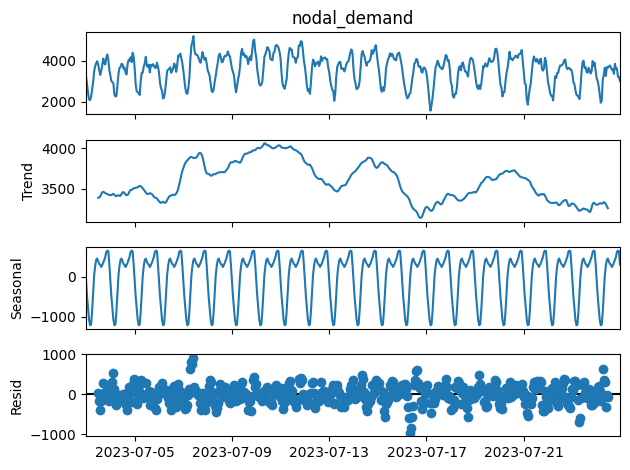

In [14]:
decomposition = seasonal_decompose(
    filtered_df["nodal_demand"], model="additive", period=24
)
decomposition.plot()
plt.show()

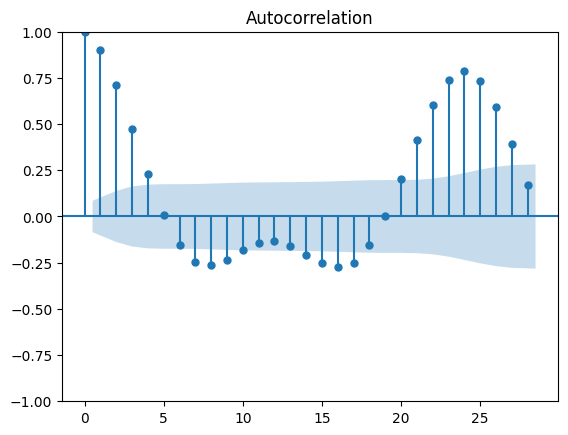

In [15]:
plot_acf(filtered_df["nodal_demand"])
plt.show()

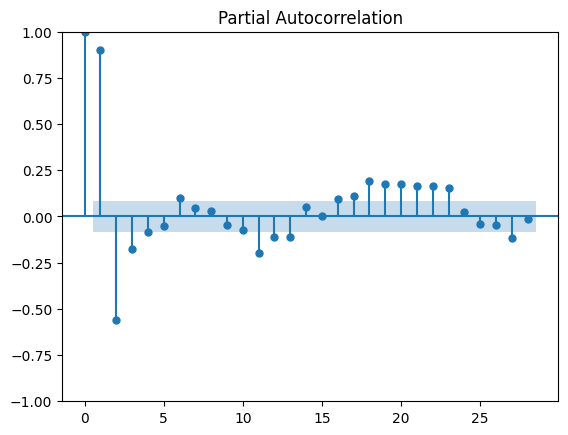

In [16]:
plot_pacf(filtered_df["nodal_demand"])
plt.show()

#### 3.2.) Fitting the model

In [17]:
rolling_seven_day_forecast = []
for days in range(0, 7):
    train_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=days)
    train_end_date = train_start_date + pd.Timedelta(days=14) - pd.Timedelta(hours=1)
    fc = train_and_forecast_sarima(filtered_df, train_start_date, train_end_date, 24)
    rolling_seven_day_forecast.append(fc)

order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4613.7
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4613.26
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4605.01
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4586.6
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4590.83
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4583.24
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4597.22


In [18]:
forecast = np.array(rolling_seven_day_forecast).flatten()
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=14)
test_end_date = test_start_date + pd.Timedelta(days=7)
measured = filtered_df.loc[
    (filtered_df.index >= test_start_date) & (filtered_df.index < test_end_date),
    ["nodal_demand"],
]
error = measured["nodal_demand"] - forecast  # Calculate error

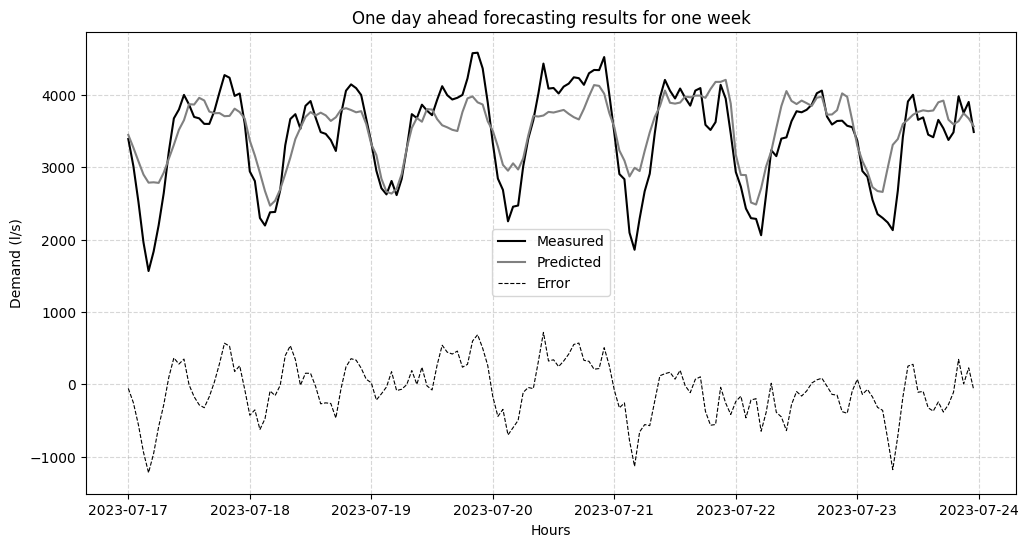

In [19]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot measured and predicted demand
plt.plot(measured.index, measured, label="Measured", color="black", linewidth=1.5)
plt.plot(measured.index, forecast, label="Predicted", color="gray", linewidth=1.5)

# Plot error
plt.plot(
    measured.index, error, label="Error", color="black", linestyle="--", linewidth=0.8
)

# Add labels, legend, and title
plt.xlabel("Hours")
plt.ylabel("Demand (l/s)")
plt.title("One day ahead forecasting results for one week")
plt.legend()

# Add grid
plt.grid(visible=True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()